# Exploration Loan Data from Prosper
## by Jannis

## Preliminary Wrangling

This data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import requests
import io

%matplotlib inline
pd.set_option('display.max_columns', 50)

In [4]:
# Loading the dataset with request libary and saving dataset as CSV file
url = 'https://s3.amazonaws.com/udacity-hosted-downloads/ud651/prosperLoanData.csv'
response = requests.get(url).content
data = pd.read_csv(io.StringIO(response.decode('utf-8')))
data.to_csv('loan_data.csv')

In [2]:
# creating new data frame called loan_data
loan_data = pd.read_csv('loan_data.csv')
loan_data.head()

,Unnamed: 0,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,...,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,NaN,NaN,NaN,NaN,NaN,NaN,0,CO,Other,Self-employed,2.0,True,True,NaN,...,NaN,NaN,NaN,0,NaN,78,19141,9425,2007-09-12 00:00:00,Q3 2007,1F3E3376408759268057EDA,330.43,11396.14,9425.00,1971.14,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,6.0,A,7.0,2,CO,Professional,Employed,44.0,False,False,NaN,...,NaN,NaN,NaN,0,NaN,0,134815,10000,2014-03-03 00:00:00,Q1 2014,1D13370546739025387B2F4,318.93,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,NaN,NaN,NaN,NaN,NaN,NaN,0,GA,Other,Not available,NaN,False,True,783C3371218786870A73D20,...,NaN,NaN,NaN,0,NaN,86,6466,3001,2007-01-17 00:00:00,Q1 2007,5F7033715035555618FA612,123.32,4186.63,3001.00,1185.63,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,6.0,A,9.0,16,GA,Skilled Labor,Employed,113.0,True,False,NaN,...,NaN,NaN,NaN,0,NaN,16,77296,10000,2012-11-01 00:00:00,Q4 2012,9ADE356069835475068C6D2,321.45,5143.20,4091.09,1052.11,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,0.18316,0.0925,0.09066,3.0,D,4.0,2,MN,Executive,Employed,44.0,True,False,NaN,...,11000.0,9947.9,NaN,0,NaN,6,102670,15000,2013-09-20 00:00:00,Q3 2013,36CE356043264555721F06C,563.97,2819.85,1563.22,1256.63,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [3]:
# high-level overview of data shape and composition
print(loan_data.shape)
print(loan_data.dtypes)

(113937, 82)
Unnamed: 0                               int64
ListingKey                              object
ListingNumber                            int64
ListingCreationDate                     object
CreditGrade                             object
Term                                     int64
LoanStatus                              object
ClosedDate                              object
BorrowerAPR                            float64
BorrowerRate                           float64
LenderYield                            float64
EstimatedEffectiveYield                float64
EstimatedLoss                          float64
EstimatedReturn                        float64
ProsperRating (numeric)                float64
ProsperRating (Alpha)                   object
ProsperScore                           float64
ListingCategory (numeric)                int64
BorrowerState                           object
Occupation                              object
EmploymentStatus                        object


### The structure of the dataset

The Data set contains 113,937 loans (rows) with 81 variables (columns) on each loan. Most variables are integers (numeric) or strings (objects). But the dataset also has some categorical variables: for example EmploymentStatus, ProsperScore, Term, IncomeRange


### Main features of interest in the dataset

The huge dataset with a lot of informaton (81 variables) allows me to have deeper look at the question what factors affect a loan’s outcome status (Cancelled, Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue)?

This is a very critical question for banks and loan companies in order to minimize the default risk and and to set the right interest rate (including setting a proper risk premium).

This investigation might help to find out what factors predict the outcome of a loan best. 
  


### Features in the dataset that will help support the investigation

The factors that have the most influence on predicting the outcome of a loan and therefore of most interest are:

 - Term (The length of the loan expressed in months)
 - ProsperScore (custom risk score)
 - EmploymentStatus (The employment status of the borrower)
 - MonthlyLoanPayment (The scheduled monthly loan payment)
 - IncomeRange (The income range of the borrower at the time the listing was created)
 - BorrowerRate (The Borrower's interest rate for this loan)
 - LoanOriginalAmount (The origination amount of the loan)
 - OpenCreditLines (Number of open credit line)
 - TotalProsperPaymentsBilled (number of on time payments the borrower made on Prosper loans at the time they created this listing)
 - Recommendations (Number of recommendations the borrower had at the time the listing was created)

Whereby I expect  to have  `ProsperScore`, `TotalProsperPaymentsBilled`, `EmploymentStatus`, `BorrowerRate`,  (high interest rate are associated with higher default risk) and `Income Range`  have  the strongest effect on the loan's outcome status.
 

#### In the first step I will create a copy of the dataset with the variables of interest

In [5]:
# create a copy of the dataset
loan_data_clean = loan_data.copy()
# include all variables that are needed in the investigation in the clean copy
loan_data_clean = loan_data_clean[['Term','ProsperScore','EmploymentStatus', 'MonthlyLoanPayment', 'Recommendations','BorrowerAPR','BorrowerRate','LoanOriginalAmount', 'OpenCreditLines','StatedMonthlyIncome','TotalProsperPaymentsBilled', 'IncomeRange']]
#getting a overview over the new dataset
print(loan_data_clean.head())
print(loan_data_clean.info())

   Term  ProsperScore EmploymentStatus  MonthlyLoanPayment  Recommendations  \
0    36           NaN    Self-employed              330.43                0   
1    36           7.0         Employed              318.93                0   
2    36           NaN    Not available              123.32                0   
3    36           9.0         Employed              321.45                0   
4    36           4.0         Employed              563.97                0   

   BorrowerAPR  BorrowerRate  LoanOriginalAmount  OpenCreditLines  \
0      0.16516        0.1580                9425              4.0   
1      0.12016        0.0920               10000             14.0   
2      0.28269        0.2750                3001              NaN   
3      0.12528        0.0974               10000              5.0   
4      0.24614        0.2085               15000             19.0   

   StatedMonthlyIncome  TotalProsperPaymentsBilled     IncomeRange  
0          3083.333333                   

#### Since the variables EmploymentStatus, ProsperScore, Term, IncomeRange are basically categorical variabels, I will change their datatype till categorical

In [111]:
# changing the datatypes till categorical
loan_data_clean['ProsperScore'] = loan_data_clean['ProsperScore'].astype('category')
loan_data_clean['Term'] = loan_data_clean['Term'].astype('category')
loan_data_clean['IncomeRange'] = loan_data_clean['IncomeRange'].astype('category')
loan_data_clean['EmploymentStatus'] = loan_data_clean['EmploymentStatus'].astype('category')
print(loan_data_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112481 entries, 0 to 113936
Data columns (total 13 columns):
Term                          112481 non-null category
ProsperScore                  83397 non-null category
EmploymentStatus              110226 non-null category
MonthlyLoanPayment            112481 non-null float64
Recommendations               112481 non-null int64
BorrowerAPR                   112456 non-null float64
BorrowerRate                  112481 non-null float64
LoanOriginalAmount            112481 non-null int64
OpenCreditLines               104877 non-null float64
StatedMonthlyIncome           112481 non-null float64
TotalProsperPaymentsBilled    21258 non-null float64
IncomeRange                   112481 non-null category
 EmploymentStatus             110226 non-null category
dtypes: category(5), float64(6), int64(2)
memory usage: 13.3 MB
None


## Univariate Exploration

I'll start by looking at the distribution of the main variable of interest
 - ProsperScore 
 - TotalProsperPaymentsBilled
 - BorrowerRate
 - EmploymentStatus
 - IncomeRange
 

Source for all interpretations:
https://www.dummies.com/education/math/statistics/statistics-workbook-for-dummies-cheat-sheet/

Diamonds Data Exploration- Example Project

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.




> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

In [13]:
# getting a first overview over the variable ProsperScore
print(loan_data_clean.ProsperScore.describe())
print(loan_data_clean.ProsperScore.value_counts())

count    84853.000000
mean         5.950067
std          2.376501
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         11.000000
Name: ProsperScore, dtype: float64
4.0     12595
6.0     12278
8.0     12053
7.0     10597
5.0      9813
3.0      7642
9.0      6911
2.0      5766
10.0     4750
11.0     1456
1.0       992
Name: ProsperScore, dtype: int64


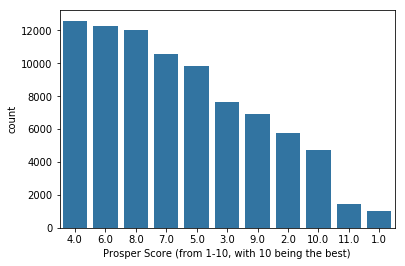

In [22]:
# Bar Chart ProsperScore (custom risk score built using historical Prosper data)
# The score ranges from 1-10, with 10 being the best, or lowest risk score)

sb.countplot(data = loan_data_clean, x = 'ProsperScore', color = base_color, order = loan_data_clean['ProsperScore'].value_counts().index)
plt.xlabel('Prosper Score (from 1-10, with 10 being the best)');

The bar chart shows that there are customers in the data set that have a score of 11 which should not be possible since the score just ranges from 1-10 which needs to be cleaned in the next step

In [39]:
# I will exclude all customers with a Prosper Score of 11
loan_data_clean = loan_data_clean[loan_data_clean['ProsperScore'] != 11]
#dubbel check if the operation was succesful
loan_data_clean[loan_data_clean['ProsperScore'] == 11]

,Term,ProsperScore,EmploymentStatus,MonthlyLoanPayment,Recommendations,BorrowerAPR,BorrowerRate,LoanOriginalAmount,OpenCreditLines,StatedMonthlyIncome,TotalProsperPaymentsBilled,IncomeRange


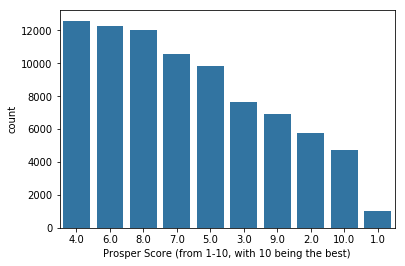

In [40]:
# now I will again plot the bar chart
sb.countplot(data = loan_data_clean, x = 'ProsperScore', color = base_color, order = loan_data_clean['ProsperScore'].value_counts().index)
plt.xlabel('Prosper Score (from 1-10, with 10 being the best)');

#### Most of the borrower have a fairly low Prosper Score of 4 (custom risk score) while the majority of the customer have a score between 5-8. You can also see that even customers with the low risks score of 1 or 2 did get a loan from Prosper. Furthermore, not many borrowers received the highest score of 10

In [99]:
# getting a first overview over the TotalProsperPaymentsBilled
loan_data.TotalProsperPaymentsBilled.describe()

count    22085.000000
mean        22.934345
std         19.249584
min          0.000000
25%          9.000000
50%         16.000000
75%         33.000000
max        141.000000
Name: TotalProsperPaymentsBilled, dtype: float64

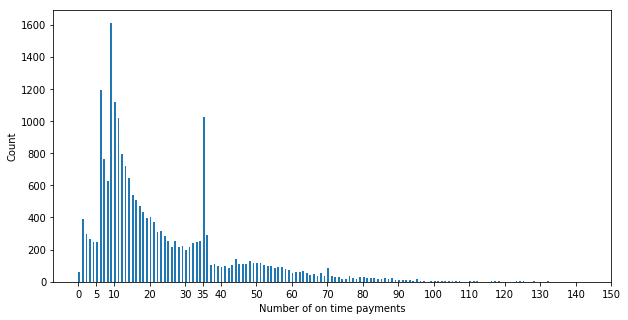

In [52]:
# Histogramm TotalProsperPaymentsBilled (Number of on time payments)
binsize = 0.5
bins = np.arange(loan_data_clean.TotalProsperPaymentsBilled.min(), loan_data_clean.TotalProsperPaymentsBilled.max()+binsize, binsize)

plt.figure(figsize=[10, 5])
plt.hist(data = loan_data_clean, x = 'TotalProsperPaymentsBilled', bins = bins)
plt.xlabel('Number of on time payments')
plt.ylabel('Count')
plt.xticks([0,5,10,20,30,35,40,50,60,70,80,90,100,110,120,130,140,150])
plt.show()

#### The distribution of the Number of on time payments is long-tailed with two peaks: 9 and 35. It is interesting to see that the distribution is right-skewed with most of the values on the lower end and fewer values on the higher end. But we observe a second uprise between 30-36. This would make the distribution roughly bi-modial. On the first view it therefore seems like that most of the borrowers had missed to pay some of the monthly payments on time.

In [53]:
# getting a first overview over the variable BorrowerRate
loan_data.BorrowerRate.describe()

count    113937.000000
mean          0.192764
std           0.074818
min           0.000000
25%           0.134000
50%           0.184000
75%           0.250000
max           0.497500
Name: BorrowerRate, dtype: float64

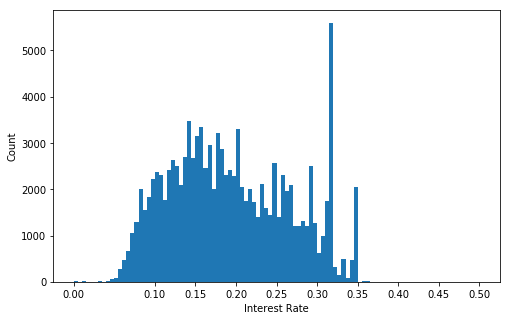

In [62]:
# Histogramm  BorrowerRate (Borrower's interest rate for this loan)
binsize = 0.005
bins = np.arange(loan_data.BorrowerRate.min(), loan_data.BorrowerRate.max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loan_data_clean, x = 'BorrowerRate', bins = bins)
plt.xlabel('Interest Rate')
plt.ylabel('Count')
plt.xticks([0.0,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])
plt.show()

#### One can see in the histogramm that most of the borrowers have an interest rate between of 0.1 and 0.25, but with a peak at around 0.33. 

In [100]:
# getting a first overview over the variable IncomeRange
print(loan_data.IncomeRange.describe())
print(loan_data.IncomeRange.value_counts())


count             113937
unique                 8
top       $25,000-49,999
freq               32192
Name: IncomeRange, dtype: object
$25,000-49,999    32192
$50,000-74,999    31050
$100,000+         17337
$75,000-99,999    16916
Not displayed      7741
$1-24,999          7274
Not employed        806
$0                  621
Name: IncomeRange, dtype: int64


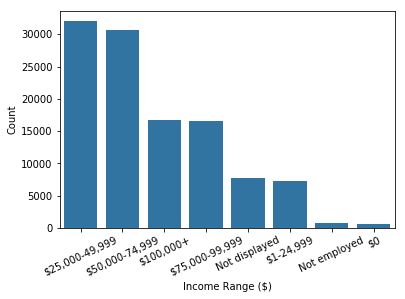

In [101]:
#Bar chart of the variable IncomeRange(The income range of the borrower at the time the listing was created)
base_color = sb.color_palette()[0]
sb.countplot(data= loan_data_clean, x= 'IncomeRange', color= base_color, order=loan_data_clean['IncomeRange'].value_counts().index)
plt.xticks(rotation=25)
plt.xlabel('Income Range ($)')
plt.ylabel('Count');

#### The income range of the borrowers shows that most of the loans where give to customers with a income between 25,000 and 74,999 which indicates that the borrowers are mostly middle-class (https://www.cnbc.com/2018/09/26/how-many-americans-qualify-as-middle-class.html). However, there are a fairly high number of borrowers that earns more than 75,000. One can also see that people that are not employed, not displayed their income or have an income of 0 received a loan from Prosper as well. They might be other criterias than income that qualifies one to get a loan at Prosper.

In [16]:
# getting a first overview over the variable EmploymentStatus
loan_data_clean.EmploymentStatus.describe()

count        19797
unique           7
top       Employed
freq         13157
Name: EmploymentStatus, dtype: object

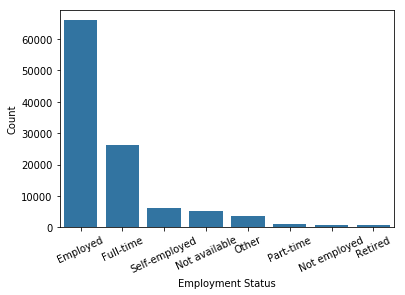

In [64]:
# plotting EmploymentStatus (The employment status of the borrower at the time they posted the listing) 
sb.countplot(data= loan_data_clean, x= 'EmploymentStatus', color= base_color, order=loan_data_clean['EmploymentStatus'].value_counts().index)
plt.xticks(rotation=25)
plt.xlabel('Employment Status')
plt.ylabel('Count');

#### As expected are most of the borrowers employed of some kind (full-time, part-time, self-emplpoyed) but the data shows that even unemployed and retired persons could get a loan.

#### Now I also will plot the remainig factors:

 - Term                                       
 - Recommendations                   
 - BorrowerAPR                                    
 - OpenCreditLines
 - LoanOriginalAmount 
 - MonthlyLoanPayment
               
  

In [65]:
# getting a first overview over the variable Term
print(loan_data_clean.Term.describe())
print(loan_data_clean.Term.value_counts())

count    112481.000000
mean         40.805932
std          10.429597
min          12.000000
25%          36.000000
50%          36.000000
75%          36.000000
max          60.000000
Name: Term, dtype: float64
36    86729
60    24138
12     1614
Name: Term, dtype: int64


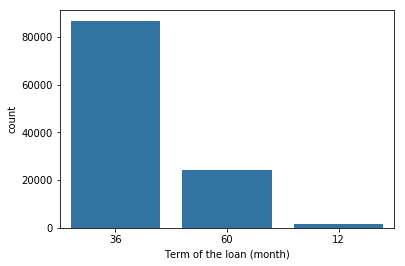

In [104]:
# Bar chart of the variable Term (The length of the loan expressed in months)
sb.countplot(data=loan_data_clean, x='Term', color=base_color, order = loan_data_clean['Term'].value_counts().index)
plt.xlabel('Term of the loan (month)');


In [67]:
loan_data_clean.LoanOriginalAmount.mean()

8252.601132635735

#### Most of the loans have of length of 36 months, followed by 60 months while just a small amounts of loans have the minium lenght of 12 months. The fact that most of the loans have a length of just 36 months might correlated to the fact the average loan amount is around 8200 dollar which can be paid back quick. 

In [70]:
# getting a first overview over the variable BorrowerAPR
print(loan_data_clean.Recommendations.describe())
print(loan_data_clean.Recommendations.value_counts())

count    112481.000000
mean          0.048221
std           0.333715
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          39.000000
Name: Recommendations, dtype: float64
0     108264
1       3480
2        562
3        108
4         26
5         14
9          6
7          5
6          4
8          3
16         2
18         2
24         1
14         1
19         1
21         1
39         1
Name: Recommendations, dtype: int64


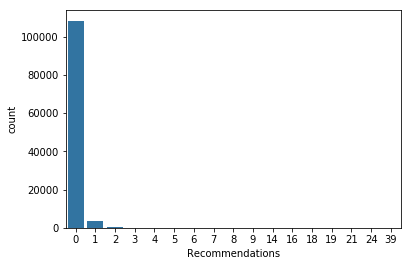

In [105]:
# plotting Recommendations(Number of recommendations the borrower had at the time of the loan)
sb.countplot(data=loan_data_clean, x = 'Recommendations', color = base_color);

#### One can see that most of the borrowers had 0 recommendations which suggest that the recommendations play a small role in the evalutation of a loan request

In [77]:
# getting a first overview over the variable OpenCreditLines
loan_data_clean.OpenCreditLines.describe()

count    104877.000000
mean          9.231633
std           5.018118
min           0.000000
25%           6.000000
50%           8.000000
75%          12.000000
max          54.000000
Name: OpenCreditLines, dtype: float64

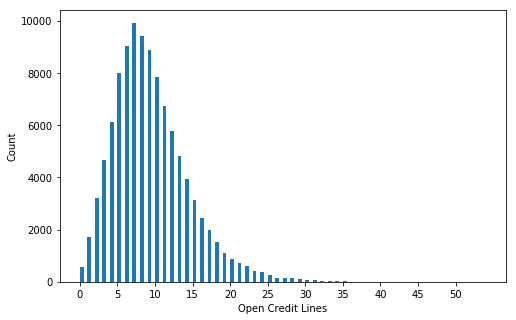

In [76]:
# Histogramm OpenCreditLines (Number of open credit lines at the time the credit profile was pulled)
binsize = 0.5
bins = np.arange(0, loan_data_clean.OpenCreditLines.max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loan_data_clean, x = 'OpenCreditLines', bins = bins)
plt.xlabel('Open Credit Lines')
plt.ylabel('Count')
plt.xticks([0,5,10,15,20,25,30,35,40,45,50])
plt.show()

#### The distribution is long-tailed and right skewed with most borrowers having between 5 and 15 open credit lines. This sounds much but without having information more information of the amount of the loans, it is hard to give a more detailed statement


In [95]:
# getting a first overview over the variable LoanOriginalAmount
print(loan_data_clean.LoanOriginalAmount.describe())
print(loan_data_clean.LoanOriginalAmount.value_counts().head(20))

count    112481.000000
mean       8252.601133
std        6172.040285
min        1000.000000
25%        4000.000000
50%        6001.000000
75%       11500.000000
max       35000.000000
Name: LoanOriginalAmount, dtype: float64
4000     14289
15000    12176
10000    10994
5000      6941
2000      6029
3000      5722
25000     3536
1000      3206
20000     3070
2500      2982
7500      2965
7000      2936
6000      2839
3500      2552
8000      2418
12000     1872
9000      1665
1500      1507
13000     1477
4500      1397
Name: LoanOriginalAmount, dtype: int64


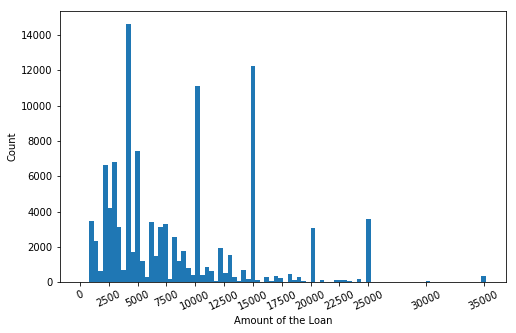

In [93]:
# Histogramm LoanOriginalAmount (The origination amount of the loan)
binsize = 400
bins = np.arange(0, loan_data_clean.LoanOriginalAmount.max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loan_data_clean, x = 'LoanOriginalAmount', bins = bins)
plt.xlabel('Amount of the Loan')
plt.ylabel('Count')
plt.xticks([0,2500,5000,7500,10000,12500,15000,17500,20000,22500,25000,30000,35000], rotation=25)
plt.show()

#### The distribution has serval peaks at around 4,000, 10,000 and 15,000. But most of the values are in the lower end between 2500 and 10,000. The most loaned amounts are 4,000 and 15,000. Its a little bit suprising that the two most loaned amounts have such a difference in terms of the loan amount. One would expect one peak but maybe Prosper targets several customer groups.

In [102]:
# getting a first overview over the variable MonthlyLoanPayment
print(loan_data_clean.MonthlyLoanPayment.describe())

count    112481.000000
mean        270.513906
std         191.234362
min           0.000000
25%         130.760000
50%         215.990000
75%         369.040000
max        2251.510000
Name: MonthlyLoanPayment, dtype: float64


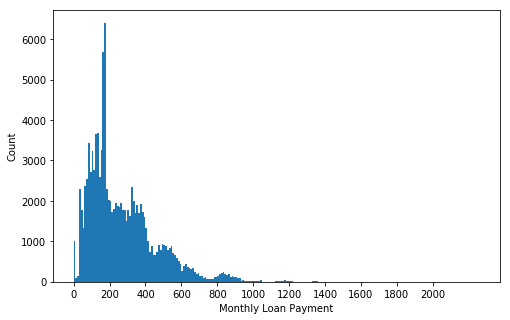

In [103]:
# Histogramm MonthlyLoanPayment (scheduled monthly loan payment)
binsize = 10
bins = np.arange(loan_data_clean.MonthlyLoanPayment.min(), loan_data_clean.MonthlyLoanPayment.max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loan_data_clean, x = 'MonthlyLoanPayment', bins = bins)
plt.xlabel('Monthly Loan Payment')
plt.ylabel('Count')
plt.xticks([0,200,400,600,800,1000,1200,1400,1600,1800,2000])
plt.show()

#### The distribution is right skrewed and long-tailed with a lot of loans with small montly payments. The peak is at around 200. A strange observation is the fact that around 1000 loans have a monthly payment of 0 which doesnt really make sense but might be related to some special arrangement (for example: the customer does not need to pay back the loan during the first 6 months). Therefore, I decided to the keep these values in the dataset.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?


> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?
Since the variables EmploymentStatus, ProsperScore, Term, IncomeRange are basically categorical variabels, I will change their datatype till categorical

The bar chart shows that there are customers in the data set that have a score of 11 which should not be possible since the score just ranges from 1-10 which needs to be cleaned in the next step

hat around 1000 loans have a monthly payment of 0 which doesnt really make sense but might be related to some special arrangement (for example: the customer does not need to pay back the loan during the first 6 months). Therefore, I decided to the keep these values in the dataset.

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

### Engineering a new variable

In [50]:
print(loan_data_clean.StatedMonthlyIncome.head())
print(loan_data_clean.MonthlyLoanPayment.head())

0    3083.333333
1    6125.000000
2    2083.333333
3    2875.000000
4    9583.333333
Name: StatedMonthlyIncome, dtype: float64
0    330.43
1    318.93
2    123.32
3    321.45
4    563.97
Name: MonthlyLoanPayment, dtype: float64


In [43]:
# in the first step I create a new variable ratio_income_loanPayment
loan_data_clean['ratio_income_loanPayment'] = (loan_data_clean.MonthlyLoanPayment / loan_data_clean.StatedMonthlyIncome)*100
# round the ratio to 2 decimals
loan_data_clean['ratio_income_loanPayment'] = loan_data_clean['ratio_income_loanPayment'].round(2)
print(loan_data_clean['ratio_income_loanPayment'].sample(3))
print(loan_data_clean['ratio_income_loanPayment'].describe())

14647    7.16
41035    2.09
66663    8.55
Name: ratio_income_loanPayment, dtype: float64
count    113922.00
mean           inf
std            NaN
min           0.00
25%           2.86
50%           4.96
75%           7.86
max            inf
Name: ratio_income_loanPayment, dtype: float64


One can see from the statisitcs that there are null values and values generate by dividing by zero

In [37]:
loan_data_clean.StatedMonthlyIncome.value_counts().head(20)

4166.666667     3526
5000.000000     3389
3333.333333     2917
3750.000000     2428
5416.666667     2374
5833.333333     2319
6250.000000     2276
2500.000000     2256
4583.333333     2211
6666.666667     2162
2916.666667     1984
8333.333333     1680
4333.333333     1527
7083.333333     1464
7500.000000     1448
3500.000000     1394
0.000000        1394
10000.000000    1282
4000.000000     1260
2083.333333     1256
Name: StatedMonthlyIncome, dtype: int64

In [38]:
loan_data_clean.MonthlyLoanPayment.value_counts().head(20)

173.71    2423
0.00       935
172.76     536
86.85      472
174.20     460
130.28     370
163.28     286
326.62     280
166.54     277
136.98     277
165.15     271
161.99     265
169.78     256
163.56     252
45.24      248
168.17     246
168.89     227
87.10      187
67.85      184
166.73     183
Name: MonthlyLoanPayment, dtype: int64